In [27]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np

# Load the datasets
assessments = pd.read_csv('assessments.csv')
courses = pd.read_csv('courses.csv')
student_assessment = pd.read_csv('studentAssessment.csv')
student_info = pd.read_csv('studentInfo.csv')
student_registration = pd.read_csv('studentRegistration.csv')
student_vle = pd.read_csv('studentVle.csv')
vle = pd.read_csv('vle.csv')

# Step 2: Merge Relevant Data
# Merge studentAssessment with assessments to get module and presentation data
student_assessments = pd.merge(student_assessment, assessments, on='id_assessment')

# Merge with studentInfo to include demographic and educational background
student_data = pd.merge(student_assessments, student_info, on=['id_student', 'code_module', 'code_presentation'])

# Merge with studentVle to include sum of clicks data
student_data = pd.merge(student_data,
                        student_vle.groupby(['id_student', 'code_module', 'code_presentation'])['sum_click'].sum().reset_index(),
                        on=['id_student', 'code_module', 'code_presentation'],
                        how='left')

# Step 3: Select and Rename Columns
final_student_data = student_data[['id_student', 'highest_education', 'age_band', 'num_of_prev_attempts',
                                   'region', 'disability', 'code_module', 'score', 'sum_click', 'final_result']]

final_student_data.columns = ['Student_id', 'Highest_education', 'Age_band', 'Number_of_previous_attempts',
                              'Region', 'Disability', 'Code_module', 'Assessment_score', 'Student_sum_click',
                              'Student_final_result']

# Save to CSV
final_student_data.to_csv('Student_Assessment.csv', index=False)

# Step 4: Data Preprocessing on Student Assessment CSV File

# Reload the newly created CSV for preprocessing
student_assessment_df = pd.read_csv('Student_Assessment.csv')

# Ensure numeric columns are properly formatted
student_assessment_df['Assessment_score'] = pd.to_numeric(student_assessment_df['Assessment_score'], errors='coerce')
student_assessment_df['Student_sum_click'] = pd.to_numeric(student_assessment_df['Student_sum_click'], errors='coerce')

# Check for Missing Values
print(f"Missing values before handling:\n{student_assessment_df.isnull().sum()}")

# Handling Missing Values
student_assessment_df.fillna(student_assessment_df.mean(numeric_only=True), inplace=True)  # For numeric columns
student_assessment_df.fillna('Unknown', inplace=True)  # For categorical columns

# Check again for missing values
print(f"Missing values after handling:\n{student_assessment_df.isnull().sum()}")

# Removing Duplicates
duplicates = student_assessment_df.duplicated()
print(f"Number of duplicate rows: {duplicates.sum()}")
student_assessment_df.drop_duplicates(inplace=True)
print(f"Number of duplicate rows after removal: {student_assessment_df.duplicated().sum()}")

# Handling Outliers
# Removing rows where 'Assessment_score' is beyond 3 standard deviations
z_scores = np.abs((student_assessment_df['Assessment_score'] - student_assessment_df['Assessment_score'].mean()) /
                  student_assessment_df['Assessment_score'].std())
student_assessment_df = student_assessment_df[z_scores < 3]

# Normalization/Standardization
scaler = StandardScaler()
numerical_cols = ['Assessment_score', 'Student_sum_click']
student_assessment_df[numerical_cols] = scaler.fit_transform(student_assessment_df[numerical_cols])

# Feature Selection
# Drop columns that may not be relevant for the current analysis
features_to_drop = ['Region', 'Disability']  # Adjust this list as needed
student_assessment_df.drop(columns=features_to_drop, inplace=True)

# Save the final preprocessed data
student_assessment_df.to_csv('Student_Assessment_Preprocessed.csv', index=False)

print("Data preprocessing complete. Preprocessed data saved to 'Student_Assessment_Preprocessed.csv'.")


Missing values before handling:
Student_id                       0
Highest_education                0
Age_band                         0
Number_of_previous_attempts      0
Region                           0
Disability                       0
Code_module                      0
Assessment_score               173
Student_sum_click              168
Student_final_result             0
dtype: int64
Missing values after handling:
Student_id                     0
Highest_education              0
Age_band                       0
Number_of_previous_attempts    0
Region                         0
Disability                     0
Code_module                    0
Assessment_score               0
Student_sum_click              0
Student_final_result           0
dtype: int64
Number of duplicate rows: 31752
Number of duplicate rows after removal: 0


<ipython-input-27-0608250bdbda>:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  student_assessment_df[numerical_cols] = scaler.fit_transform(student_assessment_df[numerical_cols])


Data preprocessing complete. Preprocessed data saved to 'Student_Assessment_Preprocessed.csv'.


# Import necessary libraries

In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns


# Load the preprocessed dataset


In [29]:
data = pd.read_csv('Student_Assessment_Preprocessed.csv')

# Check missing values before handling

In [30]:
print("Missing values before handling:")
print(data.isnull().sum())

Missing values before handling:
Student_id                     0
Highest_education              0
Age_band                       0
Number_of_previous_attempts    0
Code_module                    0
Assessment_score               0
Student_sum_click              0
Student_final_result           0
dtype: int64


# Fill missing values for categorical columns

In [31]:
data['Highest_education'].fillna(data['Highest_education'].mode()[0], inplace=True)
data['Age_band'].fillna(data['Age_band'].mode()[0], inplace=True)
data['Code_module'].fillna(data['Code_module'].mode()[0], inplace=True)

<ipython-input-31-954e89237bcd>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Highest_education'].fillna(data['Highest_education'].mode()[0], inplace=True)
<ipython-input-31-954e89237bcd>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].met

# Fill missing values for numerical columns

In [32]:
data['Number_of_previous_attempts'].fillna(data['Number_of_previous_attempts'].median(), inplace=True)
data['Assessment_score'].fillna(data['Assessment_score'].median(), inplace=True)
data['Student_sum_click'].fillna(data['Student_sum_click'].median(), inplace=True)

<ipython-input-32-59c2dff49972>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Number_of_previous_attempts'].fillna(data['Number_of_previous_attempts'].median(), inplace=True)
<ipython-input-32-59c2dff49972>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when

# Check missing values after handling

In [33]:
print("Missing values after handling:")
print(data.isnull().sum())

Missing values after handling:
Student_id                     0
Highest_education              0
Age_band                       0
Number_of_previous_attempts    0
Code_module                    0
Assessment_score               0
Student_sum_click              0
Student_final_result           0
dtype: int64


# Ensure that 'Student_final_result' column has no missing or unexpected values

In [34]:
print(f"Unique values before mapping: {data['Student_final_result'].unique()}")

Unique values before mapping: ['Pass' 'Withdrawn' 'Fail' 'Distinction']


# Map the target variable 'Student_final_result' (Fail=0, Pass=1, Distinction=2)

In [35]:
target_mapping = {'Fail': 0, 'Pass': 1, 'Distinction': 2}
data['Student_final_result'] = data['Student_final_result'].map(target_mapping)

# Check if there are any NaN values after mapping

In [36]:
print(f"Missing values in target after mapping: {data['Student_final_result'].isnull().sum()}")

Missing values in target after mapping: 11775


# Drop rows with NaN values in the target column

In [37]:
data.dropna(subset=['Student_final_result'], inplace=True)

# Encode other categorical columns using LabelEncoder

In [38]:
encoder = LabelEncoder()
categorical_columns = ['Highest_education', 'Age_band', 'Code_module']
for col in categorical_columns:
    data[col] = encoder.fit_transform(data[col])

# Split the data into features (X) and target (y)

In [39]:
X = data.drop(columns=['Student_final_result', 'Student_id'])  # Exclude target and ID columns
y = data['Student_final_result']

# Split the dataset into training and testing sets (80% train, 20% test)

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train a baseline Random Forest model

In [42]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

# Make predictions

In [43]:
y_pred = rf_model.predict(X_test)

# Evaluate the model

In [44]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

Classification Report:
              precision    recall  f1-score   support

         0.0       0.57      0.49      0.53      4886
         1.0       0.75      0.81      0.78     17070
         2.0       0.44      0.37      0.40      3728

    accuracy                           0.68     25684
   macro avg       0.59      0.56      0.57     25684
weighted avg       0.67      0.68      0.68     25684

Confusion Matrix:
[[ 2378  2366   142]
 [ 1631 13792  1647]
 [  153  2190  1385]]
Accuracy: 0.68


# Plot the confusion matrix

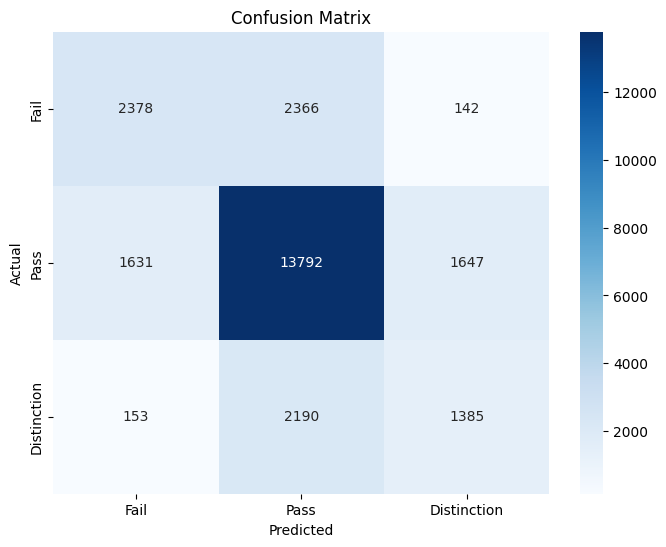

In [45]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=target_mapping.keys(), yticklabels=target_mapping.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


# Hyperparameter tuning using GridSearchCV

In [46]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
    }

grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=5,
                           scoring='accuracy',
                           verbose=2,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 20, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 150]},
             scoring='accuracy', verbose=2)

# Best parameters and model evaluation

In [47]:
print(f"Best Parameters: {grid_search.best_params_}")
best_model = grid_search.best_estimator_
y_pred_tuned = best_model.predict(X_test)

print("Classification Report (Tuned Model):")
print(classification_report(y_test, y_pred_tuned))

print(f"Accuracy (Tuned Model): {accuracy_score(y_test, y_pred_tuned):.2f}")

Best Parameters: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 150}
Classification Report (Tuned Model):
              precision    recall  f1-score   support

         0.0       0.75      0.40      0.53      4886
         1.0       0.74      0.93      0.83     17070
         2.0       0.65      0.30      0.41      3728

    accuracy                           0.74     25684
   macro avg       0.72      0.55      0.59     25684
weighted avg       0.73      0.74      0.71     25684

Accuracy (Tuned Model): 0.74


# Visualizations
# Feature Importance

<ipython-input-48-325b4c4c2c9d>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances[sorted_idx], y=features[sorted_idx], palette='viridis')


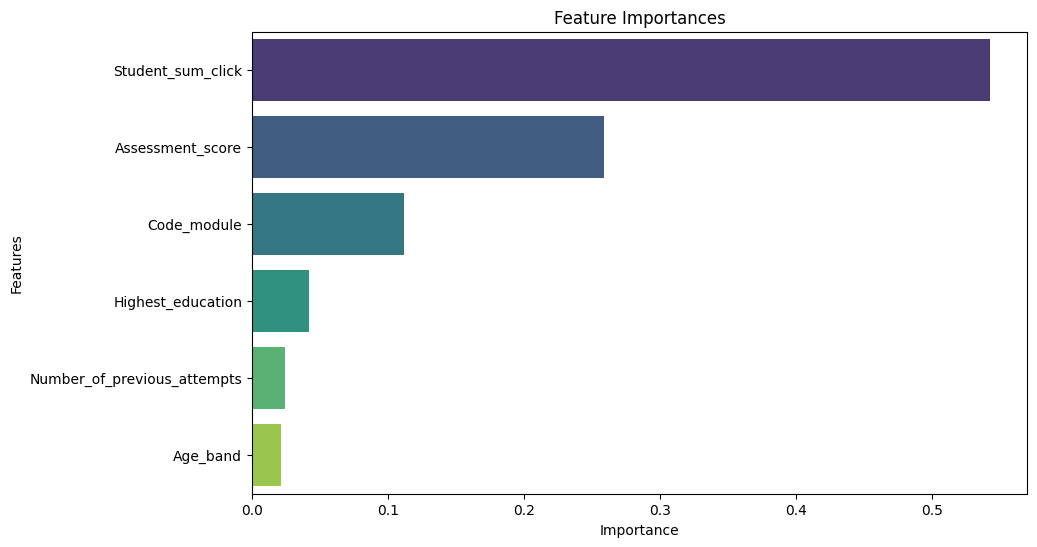

In [48]:
feature_importances = best_model.feature_importances_
features = X.columns
sorted_idx = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances[sorted_idx], y=features[sorted_idx], palette='viridis')
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

# Model Comparison (Baseline vs Tuned)

<ipython-input-49-7b0e5d25ed60>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=accuracies, palette='coolwarm')


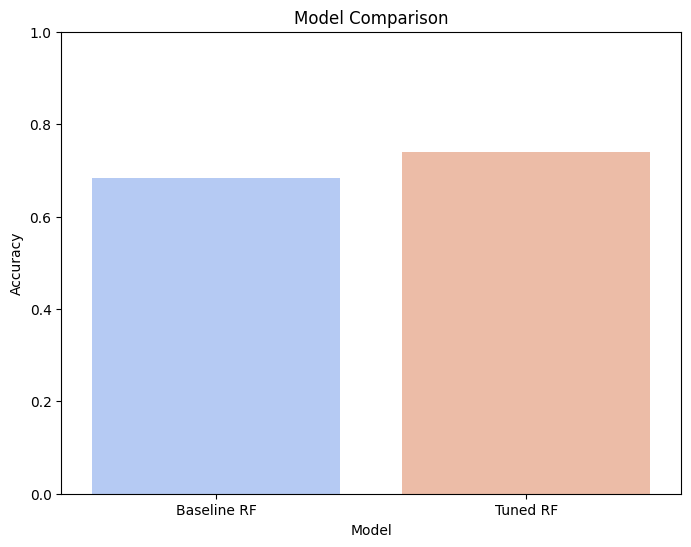

In [49]:
accuracies = [accuracy_score(y_test, y_pred), accuracy_score(y_test, y_pred_tuned)]
models = ['Baseline RF', 'Tuned RF']

plt.figure(figsize=(8, 6))
sns.barplot(x=models, y=accuracies, palette='coolwarm')
plt.ylim(0, 1)
plt.title('Model Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.show()

# Calculate the correlation matrix

In [50]:
correlation_matrix = data.corr()

# Plot the heatmap using seaborn

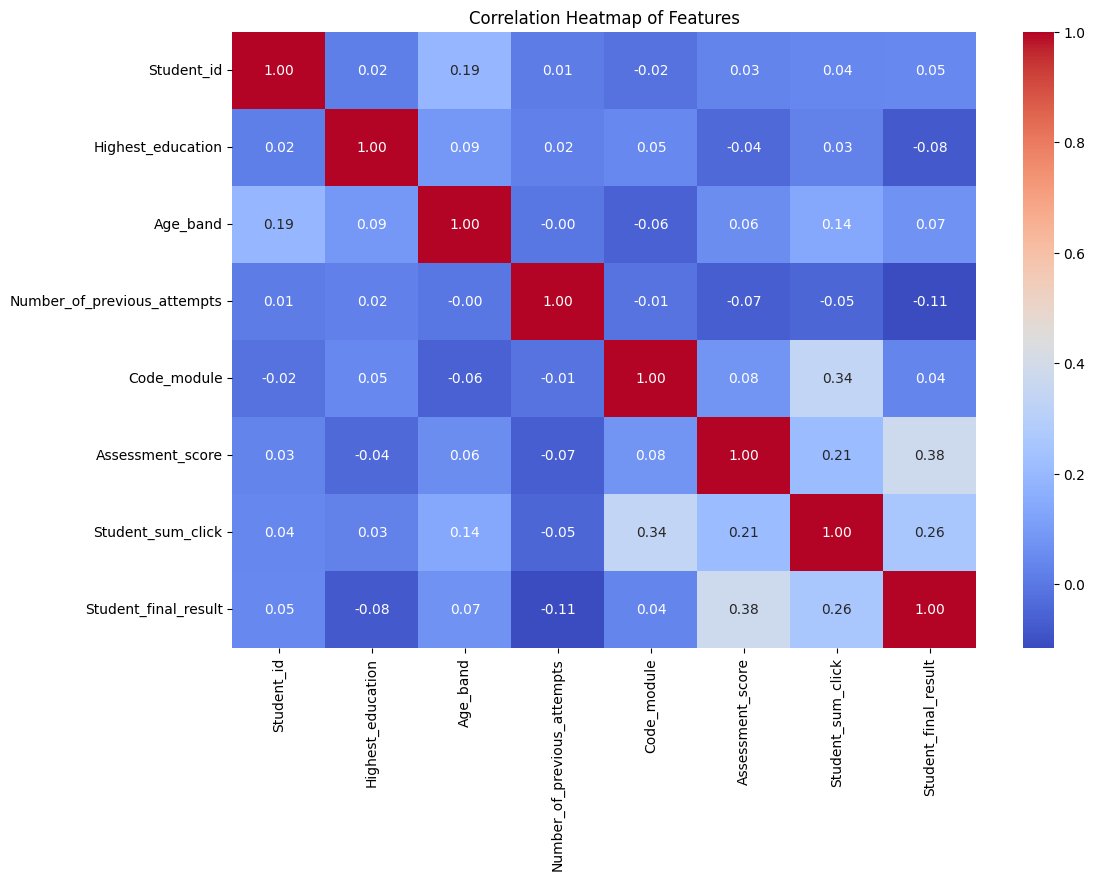

In [51]:
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap of Features')
plt.show()

# Correlation with the dependent variable

In [52]:
correlation_with_target = correlation_matrix['Student_final_result'].sort_values(ascending=False)

# Visualize correlation with the target variable

<ipython-input-53-1f6492fc3413>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation_with_target.index, y=correlation_with_target.values, palette='viridis')


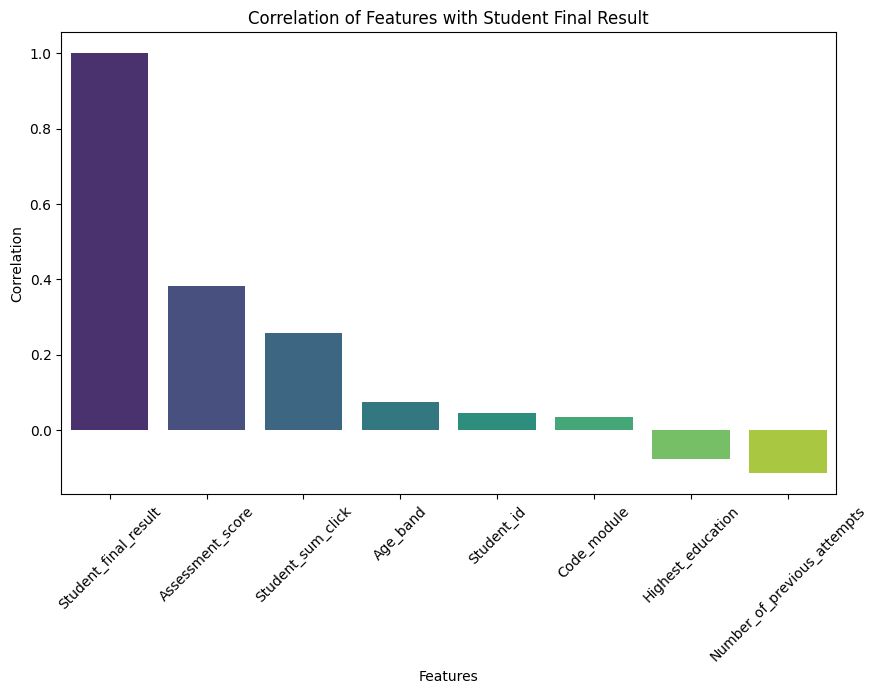

In [53]:
plt.figure(figsize=(10, 6))
sns.barplot(x=correlation_with_target.index, y=correlation_with_target.values, palette='viridis')
plt.title('Correlation of Features with Student Final Result')
plt.xlabel('Features')
plt.ylabel('Correlation')
plt.xticks(rotation=45)
plt.show()

# Import necessary libraries

In [54]:
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns


# Train and evaluate Random Forest model
# Random Forest model (tuned)

In [55]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Train and evaluate Support Vector Machine (SVM)

In [56]:
svm_model = SVC(random_state=42)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

# Train and evaluate Naive Bayes

In [57]:
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)

# Evaluate and compare all models
# Random Forest evaluation

In [58]:
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

print("Random Forest Confusion Matrix:")
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
print(conf_matrix_rf)

Random Forest Classification Report:
              precision    recall  f1-score   support

         0.0       0.57      0.49      0.53      4886
         1.0       0.75      0.81      0.78     17070
         2.0       0.44      0.37      0.40      3728

    accuracy                           0.68     25684
   macro avg       0.59      0.56      0.57     25684
weighted avg       0.67      0.68      0.68     25684

Random Forest Confusion Matrix:
[[ 2378  2366   142]
 [ 1631 13792  1647]
 [  153  2190  1385]]


# SVM evaluation

In [59]:
print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))

print("SVM Confusion Matrix:")
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
print(conf_matrix_svm)

SVM Classification Report:
              precision    recall  f1-score   support

         0.0       0.72      0.13      0.23      4886
         1.0       0.68      0.98      0.80     17070
         2.0       0.62      0.04      0.08      3728

    accuracy                           0.68     25684
   macro avg       0.67      0.39      0.37     25684
weighted avg       0.68      0.68      0.59     25684

SVM Confusion Matrix:
[[  653  4230     3]
 [  248 16724    98]
 [    5  3560   163]]


# Naive Bayes evaluation

In [60]:
print("Naive Bayes Classification Report:")
print(classification_report(y_test, y_pred_nb))

print("Naive Bayes Confusion Matrix:")
conf_matrix_nb = confusion_matrix(y_test, y_pred_nb)
print(conf_matrix_nb)

Naive Bayes Classification Report:
              precision    recall  f1-score   support

         0.0       0.47      0.29      0.36      4886
         1.0       0.69      0.85      0.77     17070
         2.0       0.41      0.18      0.25      3728

    accuracy                           0.65     25684
   macro avg       0.53      0.44      0.46     25684
weighted avg       0.61      0.65      0.61     25684

Naive Bayes Confusion Matrix:
[[ 1424  3432    30]
 [ 1540 14585   945]
 [   67  2974   687]]


# Compare model performance using accuracy score

In [61]:
accuracies = [accuracy_score(y_test, y_pred_rf), accuracy_score(y_test, y_pred_svm), accuracy_score(y_test, y_pred_nb)]
models = ['Random Forest', 'SVM', 'Naive Bayes']


# Model Comparison: Accuracy

<ipython-input-62-273c543a6863>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=accuracies, palette='coolwarm')


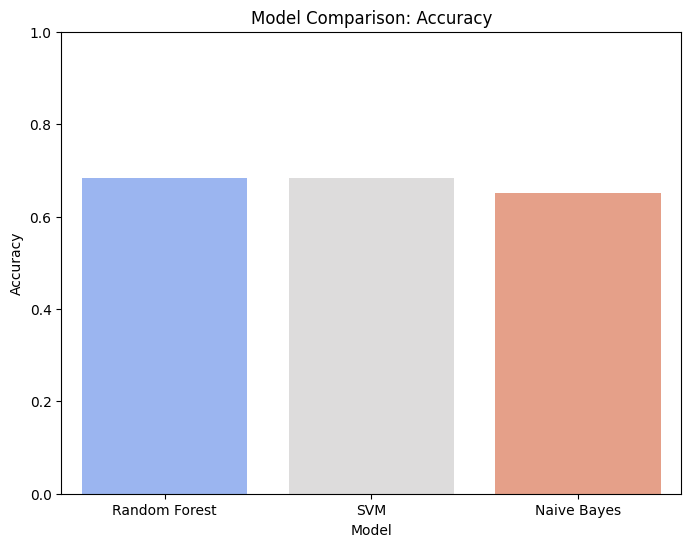

In [62]:
plt.figure(figsize=(8, 6))
sns.barplot(x=models, y=accuracies, palette='coolwarm')
plt.ylim(0, 1)
plt.title('Model Comparison: Accuracy')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.show()

# Compare feature importances (Random Forest only) for visualization
# Feature importance visualization (Only for Random Forest)

<ipython-input-63-bcba2225bcac>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances_rf[sorted_idx_rf], y=X.columns[sorted_idx_rf], palette='viridis')


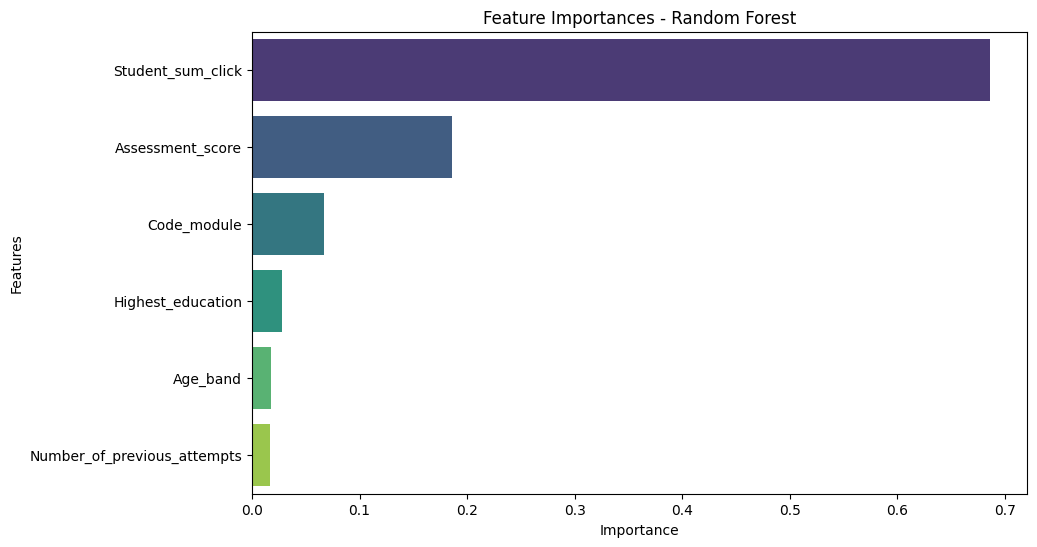

In [63]:
feature_importances_rf = rf_model.feature_importances_
sorted_idx_rf = np.argsort(feature_importances_rf)[::-1]

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances_rf[sorted_idx_rf], y=X.columns[sorted_idx_rf], palette='viridis')
plt.title('Feature Importances - Random Forest')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

# Plot confusion matrices for all models
# Random Forest Confusion Matrix

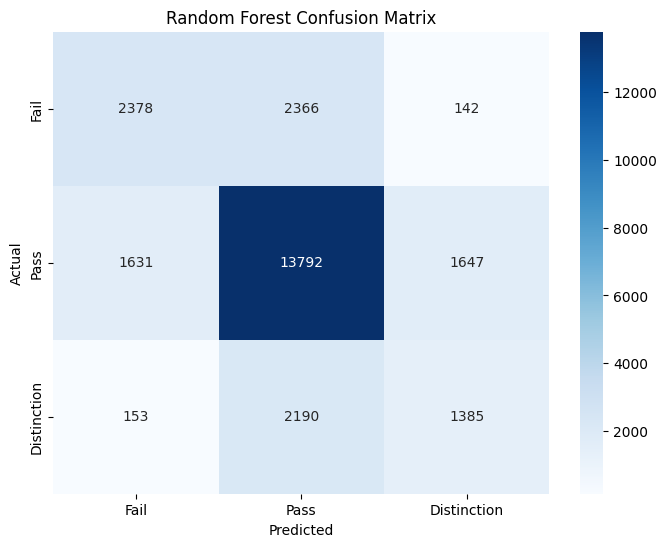

In [64]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', xticklabels=target_mapping.keys(), yticklabels=target_mapping.keys())
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# SVM Confusion Matrix

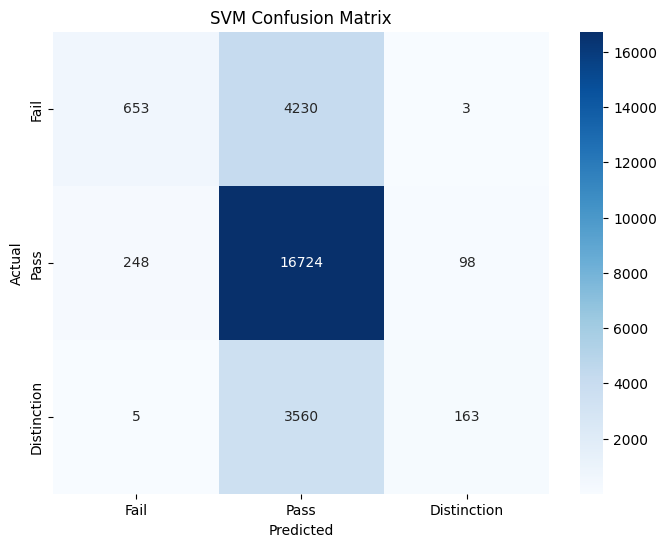

In [65]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Blues', xticklabels=target_mapping.keys(), yticklabels=target_mapping.keys())
plt.title('SVM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


# Naive Bayes Confusion Matrix

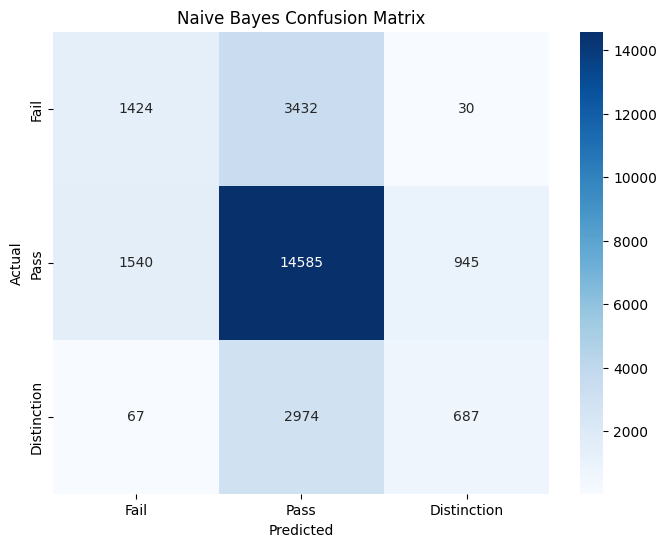

In [66]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_nb, annot=True, fmt='d', cmap='Blues', xticklabels=target_mapping.keys(), yticklabels=target_mapping.keys())
plt.title('Naive Bayes Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
